In [117]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import repeat
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
import xgboost as xgb
#import lasio
from sklearn.metrics import mean_absolute_error as mae
from os import listdir
from matplotlib_venn import venn2, venn3
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
%matplotlib inline

In [118]:
np.set_printoptions(precision=3, suppress=True)

In [119]:
def conv(s):
    if s == '':
        return np.nan
    return float(s.replace(',', '.'))

columns_to_conv = ['Нефть, т', 'Конденсат, т', 'Приемистость, м3/сут', 'Обводненность (вес), %', 'Нефть, м3', 'Жидкость, м3', \
                    'Дебит конденсата', 'Добыча растворенного газа, м3', 'Дебит попутного газа, м3/сут']
convertors = dict(zip(columns_to_conv, repeat(conv.__call__, len(columns_to_conv))))

def conv_date(x):
    if x.day != 1:
        return (x + pd.offsets.MonthBegin(1))
    else:
        return x

### Загружаем данные

In [4]:
df_train = pd.read_csv('init/1/train_1.8.csv', header = 0 ,encoding = 'cp1251', parse_dates = ['Дата'], converters= convertors)
df_test = pd.read_csv('init/1/test_1.9.csv', header = 0 ,encoding = 'cp1251', parse_dates = ['Дата'], converters= convertors)

df_coord_train = pd.read_csv('init/1/coords_train_1.1.csv', header = 0,encoding = 'cp1251')
df_coord_test = pd.read_csv('init/1/coords_test_1.1.csv', header = 0,encoding = 'cp1251')
df_coord_train = df_coord_train.rename(columns={'well_hash' : 'Скважина'})
df_coord_test = df_coord_test.rename(columns={'well_hash' : 'Скважина'})
df_coord_train_gr = df_coord_train.groupby('Скважина').mean().reset_index()
df_coord_test_gr = df_coord_test.groupby('Скважина').mean().reset_index()

df_frac_train = pd.read_csv('init/1/frac_train_1.csv', header = 0,encoding = 'cp1251')
df_frac_test = pd.read_csv('init/1/frac_test_1.csv', header = 0,encoding = 'cp1251')

df_gdis_train = pd.read_csv('init/1/gdis_train1.2.csv', header = 0,encoding = 'cp1251')
df_gdis_test = pd.read_csv('init/1/gdis_test1.2.csv', header = 0,encoding = 'cp1251')
df_gdis_train_gr = df_gdis_train.groupby('Скважина').mean().reset_index()
df_gdis_test_gr = df_gdis_test.groupby('Скважина').mean().reset_index()

In [124]:
df_all_train = pd.read_csv('./out/train_formated.csv', dtype={'frac':'int8'})
df_all_test = pd.read_csv('./out/test_formatted.csv', dtype={'frac':'int8'})

### Центруем координаты (может и не надо)

In [ ]:
df_coord_train['x'] = df_coord_train['ПЛАСТ_X'].astype(dtype='int32')
df_coord_train['y'] = df_coord_train['ПЛАСТ_Y'].astype(dtype='int32')
df_coord_train['x'] = df_coord_train['x'] - df_coord_train['x'].mean()
df_coord_train['y'] = df_coord_train['y'] - df_coord_train['y'].mean()

df_coord_train['x_head'] = df_coord_train['УСТЬЕ_X'].astype(dtype='int32')
df_coord_train['y_head'] = df_coord_train['УСТЬЕ_Y'].astype(dtype='int32')
df_coord_train['x_head'] = df_coord_train['x_head'] - df_coord_train['x_head'].mean()
df_coord_train['x_head'] = df_coord_train['x_head'] - df_coord_train['x_head'].mean()

In [ ]:
%matplotlib notebook
plt.figure(figsize=(10,10))
plt.scatter(df_coord_train.drop_duplicates('Скважина', 'first')['ПЛАСТ_X'], 
            df_coord_train.drop_duplicates('Скважина', 'first')['ПЛАСТ_Y'], color = 'g', label='train')
plt.scatter(df_coord_test.drop_duplicates('Скважина', 'first')['ПЛАСТ_X'], 
            df_coord_test.drop_duplicates('Скважина', 'first')['ПЛАСТ_Y'], color = 'r', label='test')
plt.legend()

In [177]:
w_coord_train = df_coord_train['Скважина'].unique()
w_coord_test = df_coord_test['Скважина'].unique()
w_train = df_train['Скважина'].unique()
w_test = df_test['Скважина'].unique()
w_frac_train = df_frac_train['Скважина'].unique()
w_frac_test = df_frac_test['Скважина'].unique()
w_gdis_train = df_gdis_train['Скважина'].unique()
w_gdis_test = df_gdis_test['Скважина'].unique()
#las_files_train = list(map(lambda x: x[:-4], listdir('init/1/las_train2/')))
#las_files_test = list(map(lambda x: x[:-4], listdir('init/1/las_test2/')))

### Рассчитаем нужные свойства и объединим стобцы

In [125]:
df_train.loc[:, 'Дата'] = df_train['Дата'].apply(conv_date)

df_train['days_on'] = df_train['Время работы, ч']/24

df_train['oil_rate'] = df_train['Нефть, м3']/(df_train['Время работы, ч']/24)

df_train['oil_prod'] = df_train['Нефть, т']

df_train['liq_rate'] = df_train['Жидкость, м3']/(df_train['Время работы, ч']/24)

df_train.loc[df_train['liq_rate'].isnull(), 'liq_rate'] = df_train[df_train['liq_rate'].isnull()]['Дебит жидкости']

df_train.loc[df_train['oil_rate'].isnull(), 'oil_rate'] = df_train[df_train['oil_rate'].isnull()]['liq_rate'] \
                                                            *(1-df_train[df_train['oil_rate'].isnull()]['Обводненность']/100)

df_train['wct'] = 1 - df_train['Нефть, м3']/df_train['Жидкость, м3']
df_train.loc[df_train['wct'].isnull(), 'wct'] = df_train.loc[df_train['wct'].isnull(), 'Обводненность']/100

df_train['gas_rate'] = df_train['Попутный газ, м3']/(df_train['Время работы, ч']/24)
df_train.loc[df_train['gas_rate'].isnull(), 'gas_rate'] = df_train[df_train['gas_rate'].isnull()]['Газовый фактор']* \
                                                           df_train[df_train['gas_rate'].isnull()]['oil_rate'] 

df_train['gas_prod'] = df_train['Попутный газ, м3']

df_train['gf'] = df_train['Попутный газ, м3']/df_train['Нефть, т']
df_train.loc[df_train['gf'].isnull(), 'gf'] = df_train[df_train['gf'].isnull()]['Газовый фактор']

df_train['state'] = df_train['Состояние']
df_train.loc[df_train['state'].isnull(), 'state'] = df_train.loc[df_train['state'].isnull(), 'Состояние на конец месяца'] 

df_train['frac'] = df_train['Скважина'].apply(lambda x: x in df_frac_train['Скважина'].values).astype(int)

In [126]:
oil_dens_mean = df_train[df_train['Скважина'].isin(df_train['Скважина'].unique())]['Плотность нефти'].mean()

In [127]:
df_test.loc[:, 'Дата'] = df_test['Дата'].apply(conv_date)

df_test['days_on'] = df_test['Время работы, ч']/24

#df_test['oil_rate'] = df_test['Нефть, м3']/(df_test['Время работы, ч']/24)

#df_test['oil_prod'] = df_test['Нефть, т']

#df_test['liq_rate'] = df_test['Жидкость, м3']/(df_test['Время работы, ч']/24)

#df_test.loc[df_test['liq_rate'].isnull(), 'liq_rate'] = df_test[df_test['liq_rate'].isnull()]['Дебит жидкости']

#df_test.loc[df_test['oil_rate'].isnull(), 'oil_rate'] = df_test[df_test['oil_rate'].isnull()]['liq_rate'] \
#                                                            *(1-df_test[df_test['oil_rate'].isnull()]['Обводненность']/100)

df_test['wct'] = df_test['Обводненность (вес), %']/100
df_test.loc[df_test['wct'].isnull(), 'wct'] = df_test.loc[df_test['wct'].isnull(), 'Обводненность']/100

df_test['gas_rate'] = df_test['Попутный газ, м3']/df_test['days_on'] 
#df_test.loc[df_test['gas_rate'].isnull(), 'gas_rate'] = df_test[df_test['gas_rate'].isnull()]['Газовый фактор']* \
#                                                           df_test[df_test['gas_rate'].isnull()]['oil_rate'] 

df_test['gas_prod'] = df_test['Попутный газ, м3']



#df_test['gf'] = df_test['Попутный газ, м3']/df_test['Нефть, т']
#df_test.loc[df_test['gf'].isnull(), 'gf'] = df_test[df_test['gf'].isnull()]['Газовый фактор']

#df_test['state'] = df_test['Состояние']
#df_test.loc[df_test['state'].isnull(), 'state'] = df_test.loc[df_test['state'].isnull(), 'Состояние на конец месяца'] 

df_test['frac'] = df_test['Скважина'].apply(lambda x: x in df_frac_test['Скважина'].values).astype(int)

In [128]:
df_all_train_0 = df_all_train[df_all_train['month'] == 0]

In [129]:
#wells_test = df_test['Скважина'].tolist()
wells_bd1_test = df_test[~df_test['Обводненность (вес), %'].isnull()]['Скважина'].tolist()
wells_bd1_test_0 = df_all_test[df_all_test['days_on'] == 0]['Скважина'].tolist()
wells_bd1_test = list(set(wells_bd1_test) - set(wells_bd1_test_0))

wells_bd2_test = df_test[~df_test['Обводненность'].isnull()]['Скважина'].tolist()

In [ ]:
venn3(subsets = [set(wells_bd1_test), set(wells_bd1_test_0), set(wells_bd2_test)],
     set_labels = ['bd1', 'bd1_0', 'bd2'])
print(len(wells_bd1_test) + len(wells_bd1_test_0) + len(wells_bd2_test) == len(w_test))

In [130]:
wells_bd1_train = df_train[~df_train['Обводненность (вес), %'].isnull()]['Скважина'].unique().tolist()
wells_bd2_train = df_train[~df_train['Обводненность'].isnull()]['Скважина'].unique().tolist()
wells_bd2_train = list(set(wells_bd2_train) & set(df_all_train_0['Скважина'].tolist()))
wells_bd1_train = list(set(wells_bd1_train) & set(df_all_train_0['Скважина'].tolist()))

In [ ]:
venn3(subsets = [set(wells_bd1_train), set(wells_bd2_train), set(w_train)],
     set_labels = ['bd1', 'bd2', 'all train'])
print(len(wells_bd1_train) + len(wells_bd2_train)  == len(w_train))

In [ ]:
len(list(set(wells_bd1_train) & set(wells_bd2_train)))

In [ ]:
len(list(set(wells_bd1_test) & set(wells_bd2_test)))

In [ ]:
len(wells_bd1_train)

In [ ]:
len(wells_bd2_train)

In [131]:
df_train_bd1 = df_all_train_0[(df_all_train_0['Скважина'].isin(wells_bd1_train))  & (df_all_train_0['days_on'] > 0)]

df_train_bd1.loc[:, 'Давление пластовое'] = df_train_bd1['Давление пластовое'].fillna(df_train_bd1['Давление пластовое'].mean())

df_train_bd1.loc[:, 'wct'] = df_train_bd1['wct'].fillna(0.0)

df_train_bd1.loc[:, 'frac'] = df_train_bd1['frac'].astype('int8')

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [132]:
X_clust = df_train_bd1[(~df_train_bd1['clust'].isnull())]. \
                dropna(subset = ['wct', 'gas_rate', 'frac'])[['wct', 'gas_rate', 'frac']]
y_clust = df_train_bd1[(~df_train_bd1['clust'].isnull())]. \
            dropna(subset = ['wct', 'gas_rate', 'frac'])['clust']
X_clust_test = df_train_bd1[(df_train_bd1['clust'].isnull())].\
                dropna(subset = ['wct', 'gas_rate', 'frac'])[['wct', 'gas_rate', 'frac']]


In [133]:
df_test_bd1 = df_all_test[(df_all_test['Скважина'].isin(wells_bd1_test))]
df_test_bd1.loc[df_test_bd1['Давление пластовое'] ==0, 'Давление пластовое'] = df_test_bd1[df_test_bd1['Давление пластовое'] !=0].mean()
df_test_bd1.loc[:, 'Давление пластовое'] = df_test_bd1['Давление пластовое'].fillna(df_test_bd1['Давление пластовое'].mean())
df_test_bd1.loc[:, 'wct'] = df_test_bd1['wct'].fillna(0.0)
df_test_bd1.loc[:, 'frac'] = df_test_bd1['frac'].astype('int8')

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [134]:
X_clust_t = df_test_bd1[~df_test_bd1['clust'].isnull()]. \
            dropna(subset = ['wct', 'gas_rate', 'frac'])[['wct', 'gas_rate', 'frac']]
y_clust_t = df_test_bd1[~df_test_bd1['clust'].isnull()].dropna(subset = ['wct', 'gas_rate', 'frac'])['clust']
X_clust_t_test = df_test_bd1[df_test_bd1['clust'].isnull()]. \
                dropna(subset = ['wct', 'gas_rate', 'frac'])[['wct', 'gas_rate', 'frac']]

In [136]:
clust_bd1 = GradientBoostingClassifier()
#clust_cat_bd1 = CatBoostClassifier()
cross_validate(clust_bd1, pd.concat((X_clust, X_clust_t), axis = 0) , pd.concat((y_clust, y_clust_t), axis = 0))

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.355, 0.335, 0.309]),
 'score_time': array([0.002, 0.002, 0.002]),
 'test_score': array([0.644, 0.57 , 0.536]),
 'train_score': array([1.   , 0.994, 0.994])}

In [137]:
clust_bd1.fit(pd.concat((X_clust, X_clust_t), axis = 0) , pd.concat((y_clust, y_clust_t), axis = 0))
y_clust_test = clust_bd1.predict(X_clust_test)
y_clust_t_test = clust_bd1.predict(X_clust_t_test)

In [138]:
df_train_bd1.loc[df_train_bd1['clust'].isnull(), 'clust'] = y_clust_test
df_train_bd1.loc[:, 'clust'] = df_train_bd1['clust'].astype('int8')

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [139]:
df_test_bd1.loc[df_test_bd1['clust'].isnull(), 'clust'] = y_clust_t_test
df_test_bd1.loc[:, 'clust'] = df_test_bd1['clust'].astype('int8')

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [140]:
X_bd1 = df_train_bd1[['wct', 'gas_prod', 'days_on', 'Давление пластовое', 'clust', 'frac']].dropna()
y_bd1 = df_train_bd1['oil_prod'].dropna()
X_bd1_test = df_test_bd1[['wct', 'gas_prod', 'days_on', 'Давление пластовое', 'clust', 'frac']].dropna()
#X_bd_test = df_train_bd1[df_train_bd1['Давление пластовое'].isnull()][['wct', 'gas_rate']].values
#scaler = MinMaxScaler()
#X_pr = scaler.fit_transform(X_pr)

In [ ]:
categorical_features_indices = np.where(X_bd1.dtypes != np.float)[0]

In [ ]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x_scaler.fit(pd.concat((X_bd1[['wct', 'gas_prod', 'days_on', 'Давление пластовое']], 
                        X_bd1_test[['wct', 'gas_prod', 'days_on', 'Давление пластовое']]), 
                       axis=0))
X_bd1_scaled = np.concatenate((x_scaler.transform(X_bd1[['wct', 'gas_prod', 'days_on', 'Давление пластовое']]),
                               X_bd1['clust'].values.reshape(-1,1)),
                              axis = 1)
X_bd1_test_scaled = np.concatenate((x_scaler.transform(X_bd1_test[['wct', 'gas_prod', 'days_on', 'Давление пластовое']]),
                               X_bd1_test['clust'].values.reshape(-1,1)),
                              axis = 1)

y_bd1_scaled = y_scaler.fit_transform(y_bd1.values.reshape(-1,1))

In [ ]:
pr_bd1 = GradientBoostingRegressor()
cbr_bd1 = CatBoostRegressor(verbose=False, cat_features=[4])
cross_validate(cbr_bd1, X_bd1, y_bd1, scoring='neg_mean_absolute_error')

In [ ]:
cv_params={
    'eval_metric': 'MAE',
    'verbose':False
}

cv_data = cv(
    Pool(X_bd1, y_bd1, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

In [141]:
xgb_reg = xgb.XGBRegressor()

cross_validate(xgb_reg, X_bd1, y_bd1, scoring='neg_mean_absolute_error')

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.029, 0.031, 0.032]),
 'score_time': array([0.001, 0.003, 0.002]),
 'test_score': array([ -94.591, -107.202, -107.599]),
 'train_score': array([-50.281, -46.365, -51.424])}

In [142]:
xgb_reg.fit(X_bd1, y_bd1)
feature_importances = xgb_reg.feature_importances_
feature_names = X_bd1.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score*100))

gas_prod: 47.08904027938843
wct: 17.636986076831818
days_on: 14.2123281955719
clust: 13.698630034923553
Давление пластовое: 5.479452013969421
frac: 1.883561722934246


In [ ]:
train_pool = Pool(X_bd1, y_bd1, cat_features=categorical_features_indices)
cbr_bd1 = CatBoostRegressor(verbose=False, cat_features=categorical_features_indices)
cbr_bd1.fit(train_pool)
feature_importances = cbr_bd1.get_feature_importance(train_pool)
feature_names = X_bd1.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

In [143]:
#y_bd1_test_cb = cbr_bd1.predict(X_bd1_test)
y_bd1_test_xgb = xgb_reg.predict(X_bd1_test)

In [144]:
if 'oil_prod' in df_test_bd1.columns:
    del df_test_bd1['oil_prod']
df_test_bd1['oil_prod'] = y_bd1_test_xgb
#df_test_bd1.loc[:, 'oil_prod'] = y_scaler.inverse_transform(y_bd1_test_scaled.reshape(-1,1))
df_test_bd1.loc[df_test_bd1['oil_prod']<0, 'oil_prod'] = df_test_bd1.loc[df_test_bd1['oil_prod']>0, 'oil_prod'].mean() 

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
%matplotlib inline
plt.figure(figsize=(10,10))
#plt.scatter(df_train_bd1['gas_prod'], 
#           df_train_bd1['oil_prod'], color = 'g', label='train')
plt.scatter(df_test_bd1[df_test_bd1['oil_prod']>0]['gas_prod'], 
            df_test_bd1[df_test_bd1['oil_prod']>0]['oil_prod'], color = 'r', label='test')
plt.legend()

In [145]:
df_train_time_bd1 = df_all_train[(df_all_train['Скважина'].isin(wells_bd1_train))]

df_train_time_bd1['oil_rate_1'] = np.concatenate((df_train_time_bd1['oil_rate'].values.reshape(-1,1)[1:,:], np.zeros((1,1))), axis = 0)
#df_train_time_bd1.iloc[:-1,-1] = df_train_time_bd1.iloc[1:,3]

df_train_time_bd1 = df_train_time_bd1[df_train_time_bd1['month'] != 5]

df_train_time_bd1.loc[:, 'clust'] = (df_train_time_bd1[['Скважина', 'frac']].set_index('Скважина'). \
            join(df_train_bd1[['Скважина', 'clust']].set_index('Скважина')))['clust'].values

df_train_time_bd1 = df_train_time_bd1.dropna(subset=['clust'])

df_train_time_bd1['clust'] = df_train_time_bd1['clust'].astype('int8')

df_train_time_bd1.loc[:, 'Давление пластовое'] = df_train_time_bd1.loc[:, 'Давление пластовое'].fillna(df_train_time_bd1.loc[:, 'Давление пластовое'].mean())

df_train_time_bd1.loc[df_train_time_bd1['Давление пластовое'] == 0 , 'Давление пластовое'] = df_train_time_bd1.loc[df_train_time_bd1['Давление пластовое'] != 0 , 'Давление пластовое'].mean()

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_train_time_bd1

In [146]:
X_time_bd1 = df_train_time_bd1[['oil_rate', 'frac', 'month', 'clust', 'Давление пластовое']]
y_time_bd1 = df_train_time_bd1['oil_rate_1']

In [ ]:
X_time_bd1.info()

In [ ]:
xgb_reg_time = xgb.XGBRegressor()
cross_validate(xgb_reg_time, X_time_bd1, y_time_bd1, scoring='neg_mean_absolute_error')

In [ ]:
xgb_reg_time.fit(X_time_bd1, y_time_bd1)
feature_importances = xgb_reg_time.feature_importances_
feature_names = X_time_bd1.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score*100))

In [ ]:
cat_f_ind_time = np.where(X_time_bd1.dtypes != np.float)[0]
cv_params={
    'eval_metric': 'MAE',
    'verbose':False
}

In [ ]:
cv_data = cv(
    Pool(X_time_bd1, y_time_bd1, cat_features=cat_f_ind_time),
    cv_params,
    plot=True
)

In [ ]:
train_pool_time = Pool(X_time_bd1, y_time_bd1, cat_features=cat_f_ind_time)
cbr_time_bd1 = CatBoostRegressor(verbose=False, cat_features=cat_f_ind_time)
cbr_time_bd1.fit(train_pool_time)
feature_importances = cbr_bd1.get_feature_importance(train_pool_time)
feature_names = X_time_bd1.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

In [ ]:
y_time_bd1_pred_cb = cbr_time_bd1.predict(X_time_bd1)
y_time_bd1_pred_xgb = xgb_reg_time.predict(X_time_bd1)

In [ ]:
df_train_time_bd1['oil_pred'] = y_time_bd1_pred_xgb

In [ ]:
#df_train_time_bd1.plot.scatter(x = 'oil_rate_1', y = 'oil_pred')
plt.scatter(df_train_time_bd1['oil_rate_1'], y_time_bd1_pred_cb, label = 'cb')
plt.scatter(df_train_time_bd1['oil_rate_1'], y_time_bd1_pred_xgb, label = 'xgb')
plt.legend()

In [153]:
df_test_bd1['oil_rate'] = df_test_bd1['oil_prod']/df_test_bd1['days_on']
df_test_bd1['month'] = 0

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [156]:
df_test_time_bd1 = df_test_bd1.copy()

df_test_time_bd1['month'] = 0

df_y_time_pred = df_test_time_bd1[['Скважина', 'month', 'oil_rate']].set_index(['Скважина', 'month']).unstack(0)
y_test_time_bd1 = df_test_time_bd1['oil_rate'].values
for i in range(0,5):
    
    X_test_time_bd1 = pd.concat((
                            pd.DataFrame(y_test_time_bd1, index = df_test_time_bd1['Скважина'], columns = ['oil_rate']),
                            df_test_time_bd1[['Скважина', 'frac', 'month', 'clust', 'Давление пластовое']].set_index('Скважина')
                        ), axis = 1)
    X_test_time_bd1['month'] = i
    y_test_time_bd1 = xgb_reg_time.predict(X_test_time_bd1)
    
    df_y_test_pred = pd.DataFrame(y_test_time_bd1, index = df_test_time_bd1['Скважина'], columns = ['oil_rate'])

    df_y_test_pred['month'] = i+1

    df_y_test_pred = df_y_test_pred.reset_index()


    df_y_time_pred = pd.concat((
                                df_y_time_pred,
                                df_y_test_pred.set_index(['Скважина', 'month']).unstack(0)
                         ), axis = 0)

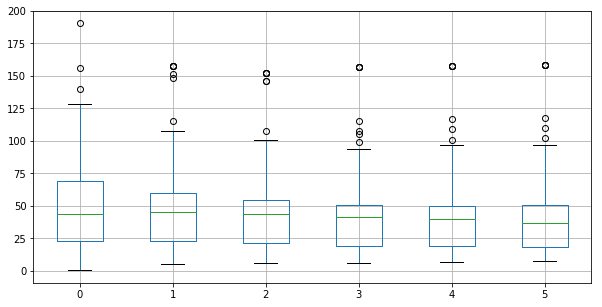

In [157]:
%matplotlib inline
plt.figure(figsize=(10,5))

df_y_time_pred[df_y_time_pred < 200].T.boxplot()
#df_y_time_pred.T.boxplot()


In [158]:
df_days_train = df_all_train[['Скважина','month', 'days_on']].set_index(['Скважина', 'month']).unstack(0).fillna(0)
df_days_train.columns = df_days_train.columns.droplevel(0)
mean_days_on = df_days_train.mean(axis = 1).values
median_days_on = df_days_train.median(axis = 1).values

In [167]:
df_pred_prod_bd1 = pd.DataFrame(df_y_time_pred.values * median_days_on.reshape(-1,1),
                                   index = df_y_time_pred.index,
                                   columns = df_y_time_pred.columns
                                  )

df_pred_prod_bd1.loc[0] = df_test_time_bd1[['Скважина', 'oil_prod']].set_index('Скважина')['oil_prod'].values

In [160]:
df_pred_bd1 = df_y_time_pred.stack().swaplevel().join(df_test_bd1[['Скважина', 'month', 'oil_prod', 'days_on']].set_index(['Скважина', 'month']))#.reset_index().set_index('Скважина')

#df_pred['oil_prod_pred'] = 0.0

#df_pred.loc[df_pred['month'] == 0, 'oil_prod_pred'] = df_test_bd1['oil_prod'].set_index('Скважина')

### Модель для скважин из БД 2

In [12]:
df_train_bd2 = pd.read_csv('./out/train_formated_3.csv')
df_train_bd2 = df_train_bd2.iloc[:,1:]
df_train_bd2['frac'] = df_train_bd2['Скважина'].apply(lambda x: x in df_frac_train['Скважина'].values).astype(int)

In [38]:
df_all_test = pd.read_csv('./out/test_formatted_3.csv')

df_test_bd2 = df_all_test[(df_all_test['Скважина'].isin(wells_bd2_test))]
df_test_bd2.loc[df_test_bd2['Давление пластовое'] ==0, 'Давление пластовое'] = df_test_bd2[df_test_bd2['Давление пластовое'] !=0].mean()
df_test_bd2.loc[:, 'Давление пластовое'] = df_test_bd2['Давление пластовое'].fillna(df_test_bd2['Давление пластовое'].mean())
df_test_bd2.loc[:, 'wct'] = df_test_bd2['wct'].fillna(0.0)
df_test_bd2.loc[:, 'frac'] = df_test_bd2['frac'].astype('int8')
df_test_bd2['month'] = 0

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
df_test_bd2

,Unnamed: 0,Скважина,Дата,Куст,Тип скважины,Диаметр экспл.колонны,Пластовое давление,Динамическая высота,Забойное давление,Обводненность,...,wct,gas_rate,gas_prod,gf,frac,num_of_pr,num_of_plast,Давление пластовое,ПЛАСТ_X,ПЛАСТ_Y
1,1,008d0347e572a5d938a9c40c29e539fc,2013-10-01,6.0,Наклонно-направленно,0.0,0.0,2357.0,0.000000,63.00,...,0.6300,NaN,NaN,90.0,0,NaN,1.0,197.367949,1.272636e+07,3.857880e+07
2,2,00b40cb7bb8c9fd1ac26b4cc86f2b291,2018-02-01,131,Горизонтально,159.6,264.0,1551.0,119.955215,52.00,...,0.5200,NaN,NaN,100.0,0,NaN,NaN,197.367949,NaN,NaN
6,6,05212b25f9130e8cd411857c9fd4366d,2018-03-01,17.0,Наклонно-направленно,146.8,229.2,3008.0,24.338805,65.00,...,0.6500,NaN,NaN,36.0,0,1.0,NaN,229.200000,NaN,NaN
33,33,1c97ea340b01c124d9bd3bcb8f789ecb,2017-11-01,17.0,Наклонно-направленно,146.8,240.0,2885.0,35.887398,35.70,...,0.3570,NaN,NaN,36.0,0,NaN,NaN,197.367949,NaN,NaN
40,40,22e8c7cf89de98e785b2dd4a1a1e3734,2018-02-01,125,Горизонтально,159.6,270.0,1746.0,114.375348,10.00,...,0.1000,NaN,NaN,96.0,0,NaN,NaN,197.367949,NaN,NaN
43,43,2411cb09993f272df1c1c3ea45392e08,2018-03-01,8.0,Горизонтально,159.6,245.0,1690.0,145.688941,60.00,...,0.6000,NaN,NaN,90.0,0,NaN,NaN,197.367949,NaN,NaN
45,45,24a639895e6aff4f5c3d78621423a664,2018-04-01,8.0,Горизонтально,159.6,250.0,2966.0,54.674013,42.00,...,0.4200,NaN,NaN,90.0,0,NaN,NaN,197.367949,NaN,NaN
47,47,256aab518eee401ea63943c8d1f5def7,2015-01-01,400.0,Вертикально,0.0,0.0,0.0,0.000000,1.00,...,0.0100,NaN,NaN,90.0,0,NaN,1.0,197.367949,1.271607e+07,3.858400e+07
48,48,27473d06263791636ee56fb7d19b4c40,2018-02-01,19В,Горизонтально,159.6,270.0,2839.0,33.404870,30.00,...,0.3000,NaN,NaN,96.0,0,NaN,NaN,197.367949,NaN,NaN
61,61,31f4b3b80fced4c6ee642b9d1ce5a20b,2017-12-01,125,Горизонтально,159.6,310.0,2978.0,31.162668,22.00,...,0.2200,NaN,NaN,96.0,0,NaN,NaN,197.367949,NaN,NaN


In [39]:
#df_train_db2_0['clust'] = 0
clust_train = KMeans(n_clusters=4)
df_train_bd2.loc[~df_train_bd2['ПЛАСТ_X'].isnull(), 'clust']  = clust_train.fit_predict(df_train_bd2[~df_train_bd2['ПЛАСТ_X'].isnull()][['ПЛАСТ_X', 'ПЛАСТ_Y']])

df_test_bd2.loc[~df_test_bd2['ПЛАСТ_X'].isnull(), 'clust'] = clust_train.predict(df_test_bd2[~df_test_bd2['ПЛАСТ_X'].isnull()][['ПЛАСТ_X', 'ПЛАСТ_Y']])

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [79]:
cols_to_fill = df_train_bd2.columns[4:16].tolist()#.remove('Дебит жидкости') 

In [80]:
cols_to_fill.remove('Дебит жидкости') 

In [90]:
for col in cols_to_fill:
    df_train_bd2.loc[df_train_bd2[col] == 0, col] = \
            df_train_bd2.loc[df_train_bd2[col] != 0, col].mean()
    if col != 'Дебит жидкости':
        df_test_bd2.loc[df_test_bd2[col] == 0, col] = \
            df_test_bd2.loc[df_test_bd2[col] != 0, col].mean()

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [91]:
df_train_bd2.loc[df_train_bd2['Давление пластовое'].isnull(), 'Давление пластовое'] = \
            df_train_bd2.loc[~df_train_bd2['Давление пластовое'].isnull(), 'Давление пластовое'].mean()
df_test_bd2.loc[df_test_bd2['Давление пластовое'].isnull(), 'Давление пластовое'] = \
            df_test_bd2.loc[~df_test_bd2['Давление пластовое'].isnull(), 'Давление пластовое'].mean()

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
df_train_bd2_0[df_train_bd2_0['Куст']=='141']

In [81]:
cols_to_fit = cols_to_fill + ['wct', 'frac', 'gf', 'Давление пластовое']

In [93]:
X_clust_bd2 = df_train_bd2[(~df_train_bd2['clust'].isnull())]. \
                dropna(subset = cols_to_fit)[cols_to_fit]
y_clust_bd2 = df_train_bd2[(~df_train_bd2['clust'].isnull())]. \
            dropna(subset = cols_to_fit)['clust']
X_clust_test_bd2 = df_train_bd2[(df_train_bd2['clust'].isnull())].\
                dropna(subset = cols_to_fit)[cols_to_fit]

In [94]:
X_clust_t_bd2 = df_test_bd2[~df_test_bd2['clust'].isnull()]. \
            dropna(subset = cols_to_fit)[cols_to_fit]
y_clust_t_bd2 = df_test_bd2[~df_test_bd2['clust'].isnull()].dropna(subset = cols_to_fit)['clust']
X_clust_t_test_bd2 = df_test_bd2[df_test_bd2['clust'].isnull()]. \
                dropna(subset = cols_to_fit)[cols_to_fit]

In [95]:
clust_bd2 = GradientBoostingClassifier()
#clust_cat_bd1 = CatBoostClassifier()
cross_validate(clust_bd2, pd.concat((X_clust_bd2, X_clust_t_bd2), axis = 0) , pd.concat((y_clust_bd2, y_clust_t_bd2), axis = 0))

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.278, 0.302, 0.329]),
 'score_time': array([0.002, 0.002, 0.001]),
 'test_score': array([0.944, 1.   , 0.972]),
 'train_score': array([1., 1., 1.])}

In [96]:
clust_bd2.fit(pd.concat((X_clust_bd2, X_clust_t_bd2), axis = 0) , pd.concat((y_clust_bd2, y_clust_t_bd2), axis = 0))
y_clust_test_bd2 = clust_bd2.predict(X_clust_test_bd2)
y_clust_t_test_bd2 = clust_bd2.predict(X_clust_t_test_bd2)

In [97]:
df_train_bd2.loc[df_train_bd2['clust'].isnull(), 'clust'] = y_clust_test_bd2
df_train_bd2.loc[:, 'clust'] = df_train_bd2['clust'].astype('int8')

In [98]:
df_test_bd2.loc[df_test_bd2['clust'].isnull(), 'clust'] = y_clust_t_test_bd2
df_test_bd2.loc[:, 'clust'] = df_test_bd2['clust'].astype('int8')

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [99]:
df_train_bd2_0 = df_train_bd2[df_train_bd2['month'] == 0]

In [103]:
df_test_bd2[cols_to_fit]

,Диаметр экспл.колонны,Пластовое давление,Динамическая высота,Забойное давление,Обводненность,Давление наcыщения,Газовый фактор,JD факт,Вязкость нефти в пластовых условиях,Плотность нефти,Высота перфорации,wct,frac,gf,Давление пластовое
1,153.44,250.264103,2357.000000,89.217621,63.00,118.0,90.0,0.382799,1.322683,0.840,9.00,0.6300,0,90.0,197.367949
2,159.60,264.000000,1551.000000,119.955215,52.00,80.0,100.0,0.421451,1.380000,0.864,5.45,0.5200,0,100.0,197.367949
6,146.80,229.200000,3008.000000,24.338805,65.00,80.9,36.0,0.396978,1.670000,0.870,21.00,0.6500,0,36.0,229.200000
33,146.80,240.000000,2885.000000,35.887398,35.70,80.9,36.0,0.403288,1.670000,0.870,8.00,0.3570,0,36.0,197.367949
40,159.60,270.000000,1746.000000,114.375348,10.00,80.0,96.0,0.421451,1.380000,0.867,4.22,0.1000,0,96.0,197.367949
43,159.60,245.000000,1690.000000,145.688941,60.00,118.0,90.0,0.421451,0.850000,0.840,864.77,0.6000,0,90.0,197.367949
45,159.60,250.000000,2966.000000,54.674013,42.00,118.0,90.0,0.397430,0.850000,0.840,474.58,0.4200,0,90.0,197.367949
47,153.44,250.264103,2130.285714,89.217621,1.00,118.0,90.0,0.382799,0.850000,0.840,8.00,0.0100,0,90.0,197.367949
48,159.60,270.000000,2839.000000,33.404870,30.00,80.0,96.0,0.403486,1.380000,0.867,5.85,0.3000,0,96.0,197.367949
61,159.60,310.000000,2978.000000,31.162668,22.00,80.0,96.0,0.403624,1.380000,0.867,4.63,0.2200,0,96.0,197.367949


In [104]:
X_bd2 = df_train_bd2_0[cols_to_fit]
y_bd2 = df_train_bd2_0['oil_rate']
X_bd2_test = df_test_bd2[cols_to_fit]
#X_bd_test = df_train_bd2[df_train_bd2['Давление пластовое'].isnull()][['wct', 'gas_rate']].values
#scaler = MinMaxScaler()
#X_pr = scaler.fit_transform(X_pr)

In [107]:
xgb_reg_2 = xgb.XGBRegressor()

cross_validate(xgb_reg_2, X_bd2, y_bd2, scoring='neg_mean_absolute_error')

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.035, 0.033, 0.033]),
 'score_time': array([0.002, 0.001, 0.002]),
 'test_score': array([-12.552, -12.907, -13.291]),
 'train_score': array([-4.481, -4.526, -4.813])}

In [108]:
xgb_reg_2.fit(X_bd2, y_bd2)
feature_importances = xgb_reg_2.feature_importances_
feature_names = X_bd2.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score*100))

Высота перфорации: 16.780821979045868
wct: 16.09589010477066
Пластовое давление: 11.64383590221405
Динамическая высота: 9.76027399301529
Диаметр экспл.колонны: 8.732876926660538
gf: 7.705479115247726
Обводненность: 7.1917809545993805
Забойное давление: 5.479452013969421
Давление пластовое: 5.3082190454006195
Газовый фактор: 4.794520512223244
JD факт: 3.4246575087308884
Вязкость нефти в пластовых условиях: 1.0273972526192665
frac: 0.8561643771827221
Плотность нефти: 0.6849315017461777
Давление наcыщения: 0.5136986263096333


In [109]:
#y_bd1_test_cb = cbr_bd1.predict(X_bd1_test)
y_bd2_test_xgb = xgb_reg_2.predict(X_bd2_test)

In [110]:
if 'oil_rate' in df_test_bd2.columns:
    del df_test_bd2['oil_rate']
df_test_bd2['oil_rate'] = y_bd2_test_xgb
#df_test_bd2.loc[:, 'oil_prod'] = y_scaler.inverse_transform(y_bd2_test_scaled.reshape(-1,1))
#df_test_bd2.loc[df_test_bd2['oil_prod']<0, 'oil_prod'] = df_test_bd2.loc[df_test_bd2['oil_prod']>0, 'oil_prod'].mean() 

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [115]:
df_train_time_bd2 = df_train_bd2[(df_train_bd2['Скважина'].isin(wells_bd2_train))]

df_train_time_bd2['oil_rate_1'] = np.concatenate((df_train_time_bd2['oil_rate'].values.reshape(-1,1)[1:,:], np.zeros((1,1))), axis = 0)
#df_train_time_bd2.iloc[:-1,-1] = df_train_time_bd2.iloc[1:,3]

df_train_time_bd2 = df_train_time_bd2[df_train_time_bd2['month'] != 5]

#df_train_time_bd2.loc[:, 'clust'] = (df_train_time_bd2[['Скважина', 'frac']].set_index('Скважина'). \
#            join(df_train_bd2[['Скважина', 'clust']].set_index('Скважина')))['clust'].values

#df_train_time_bd2 = df_train_time_bd2.dropna(subset=['clust'])

df_train_time_bd2['clust'] = df_train_time_bd2['clust'].astype('int8')

df_train_time_bd2.loc[:, 'Давление пластовое'] = df_train_time_bd2.loc[:, 'Давление пластовое'].fillna(df_train_time_bd2.loc[:, 'Давление пластовое'].mean())

df_train_time_bd2.loc[df_train_time_bd2['Давление пластовое'] == 0 , 'Давление пластовое'] = df_train_time_bd2.loc[df_train_time_bd2['Давление пластовое'] != 0 , 'Давление пластовое'].mean()

In [147]:
X_time_bd2 = df_train_time_bd2[['oil_rate', 'frac', 'month', 'clust', 'Давление пластовое']]
y_time_bd2 = df_train_time_bd2['oil_rate_1']

In [148]:
xgb_reg_time = xgb.XGBRegressor()
cross_validate(xgb_reg_time, pd.concat((X_time_bd1,X_time_bd2), axis = 0) ,
               pd.concat((y_time_bd1, y_time_bd2),axis = 0), scoring='neg_mean_absolute_error')

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.116, 0.122, 0.094]),
 'score_time': array([0.005, 0.004, 0.004]),
 'test_score': array([-4.774, -5.202, -4.399]),
 'train_score': array([-3.913, -3.992, -4.361])}

In [149]:
xgb_reg_time.fit(pd.concat((X_time_bd1,X_time_bd2), axis = 0),
                 pd.concat((y_time_bd1, y_time_bd2),axis = 0))
feature_importances = xgb_reg_time.feature_importances_
feature_names = X_time_bd1.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score*100))

oil_rate: 66.66666865348816
Давление пластовое: 17.665129899978638
month: 8.294931054115295
clust: 5.683563649654388
frac: 1.6897082328796387


In [150]:
df_test_bd2

,Unnamed: 0,Скважина,Дата,Куст,Тип скважины,Диаметр экспл.колонны,Пластовое давление,Динамическая высота,Забойное давление,Обводненность,...,gf,frac,num_of_pr,num_of_plast,Давление пластовое,ПЛАСТ_X,ПЛАСТ_Y,month,clust,oil_rate
1,1,008d0347e572a5d938a9c40c29e539fc,2013-10-01,6.0,Наклонно-направленно,153.44,250.264103,2357.000000,89.217621,63.00,...,90.0,0,NaN,1.0,197.367949,1.272636e+07,3.857880e+07,0,0,31.677822
2,2,00b40cb7bb8c9fd1ac26b4cc86f2b291,2018-02-01,131,Горизонтально,159.60,264.000000,1551.000000,119.955215,52.00,...,100.0,0,NaN,NaN,197.367949,NaN,NaN,0,0,51.441181
6,6,05212b25f9130e8cd411857c9fd4366d,2018-03-01,17.0,Наклонно-направленно,146.80,229.200000,3008.000000,24.338805,65.00,...,36.0,0,1.0,NaN,229.200000,NaN,NaN,0,3,17.876209
33,33,1c97ea340b01c124d9bd3bcb8f789ecb,2017-11-01,17.0,Наклонно-направленно,146.80,240.000000,2885.000000,35.887398,35.70,...,36.0,0,NaN,NaN,197.367949,NaN,NaN,0,3,25.970343
40,40,22e8c7cf89de98e785b2dd4a1a1e3734,2018-02-01,125,Горизонтально,159.60,270.000000,1746.000000,114.375348,10.00,...,96.0,0,NaN,NaN,197.367949,NaN,NaN,0,0,75.518867
43,43,2411cb09993f272df1c1c3ea45392e08,2018-03-01,8.0,Горизонтально,159.60,245.000000,1690.000000,145.688941,60.00,...,90.0,0,NaN,NaN,197.367949,NaN,NaN,0,0,51.848572
45,45,24a639895e6aff4f5c3d78621423a664,2018-04-01,8.0,Горизонтально,159.60,250.000000,2966.000000,54.674013,42.00,...,90.0,0,NaN,NaN,197.367949,NaN,NaN,0,0,29.536058
47,47,256aab518eee401ea63943c8d1f5def7,2015-01-01,400.0,Вертикально,153.44,250.264103,2130.285714,89.217621,1.00,...,90.0,0,NaN,1.0,197.367949,1.271607e+07,3.858400e+07,0,0,62.335880
48,48,27473d06263791636ee56fb7d19b4c40,2018-02-01,19В,Горизонтально,159.60,270.000000,2839.000000,33.404870,30.00,...,96.0,0,NaN,NaN,197.367949,NaN,NaN,0,0,44.813862
61,61,31f4b3b80fced4c6ee642b9d1ce5a20b,2017-12-01,125,Горизонтально,159.60,310.000000,2978.000000,31.162668,22.00,...,96.0,0,NaN,NaN,197.367949,NaN,NaN,0,0,44.413074


In [161]:
df_test_time_bd2 = df_test_bd2.copy()

df_test_time_bd2['month'] = 0

df_y_time_pred_bd2 = df_test_time_bd2[['Скважина', 'month', 'oil_rate']].set_index(['Скважина', 'month']).unstack(0)
y_test_time_bd2 = df_test_time_bd2['oil_rate'].values
for i in range(0,5):
    
    X_test_time_bd2 = pd.concat((
                            pd.DataFrame(y_test_time_bd2, index = df_test_time_bd2['Скважина'], columns = ['oil_rate']),
                            df_test_time_bd2[['Скважина', 'frac', 'month', 'clust', 'Давление пластовое']].set_index('Скважина')
                        ), axis = 1)
    X_test_time_bd2['month'] = i
    y_test_time_bd2 = xgb_reg_time.predict(X_test_time_bd2)
    
    df_y_test_pred = pd.DataFrame(y_test_time_bd2, index = df_test_time_bd2['Скважина'], columns = ['oil_rate'])

    df_y_test_pred['month'] = i+1

    df_y_test_pred = df_y_test_pred.reset_index()


    df_y_time_pred_bd2 = pd.concat((
                                df_y_time_pred_bd2,
                                df_y_test_pred.set_index(['Скважина', 'month']).unstack(0)
                         ), axis = 0)

In [184]:
df_pred_prod_bd2 = pd.DataFrame(df_y_time_pred_bd2.values * median_days_on.reshape(-1,1) * oil_dens_mean,
                                   index = df_y_time_pred_bd2.index,
                                   columns = df_y_time_pred_bd2.columns
                                  )

#df_y_time_pred_prod.loc[0] = df_test_time_bd1[['Скважина', 'oil_prod']].set_index('Скважина')['oil_prod'].values

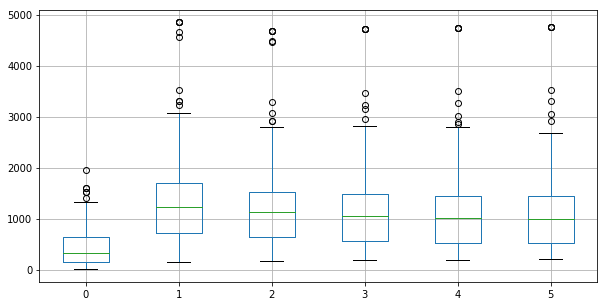

In [186]:
plt.figure(figsize=(10,5))
df_pred_prod.T.boxplot()

In [175]:
wells_pred = df_pred_prod.stack().reset_index()['Скважина'].unique().tolist()

In [178]:
wells_no_pred = list(set(w_test) - set(wells_pred))

In [180]:
df_test[df_test['Скважина'].isin(wells_no_pred)]

,Скважина,Дата,ГТМ,Метод,Характер работы,Состояние,"Время работы, ч",Время накопления,"Попутный газ, м3","Закачка, м3",...,ГП(ИДН) Дебит жидкости,ГП(ИДН) Дебит жидкости скорр-ый,ГП(ИДН) Прирост дефита нефти,ГП(ГРП) Дебит жидкости,ГП(ГРП) Дебит жидкости скорр-ый,days_on,wct,gas_rate,gas_prod,frac
0,002ff5b8a6dc271f58581e1b4fa2c5fc,2016-12-01,1.0,ФОН,НЕФ,ОСВ ТГ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,1
4,024ec6f6e3f9c5150ecf525bf8b7a6a3,2017-06-01,1.0,ФОН,НЕФ,ОСВ ТГ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,1
9,06faa5458fc276b6019187433f17e09a,2013-08-01,0.0,ФОН,НЕФ,ОСВ ТГ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,1
10,07313571fb79b736a16f00ff147f7982,2017-09-01,0.0,ФОН,НЕФ,ОСВ ТГ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,1
11,0763505542e814c5d5d133b3f192f2b0,2015-10-01,0.0,ФОН,НЕФ,ОСВ ТГ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,1
12,07830e36eba7d7a7cfce3941e910af58,2017-08-01,1.0,ЭЦН/ФОН,НЕФ,ОСВ ТГ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,1
15,0ae02477793fe6d360aae02db22bb3eb,2013-07-01,0.0,ФОН,НЕФ,ОСВ ТГ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0
16,0b61213f50cb8832771f5f8adfa32b82,2014-08-01,1.0,ЭЦН,НЕФ,ОСВ ТГ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,1
19,10deca382854f5b16498bc0254973989,2017-09-01,1.0,ФОН,НЕФ,ОСВ ТГ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,1
23,131015fe77e9fd9fc79f5db00020c734,2015-08-01,1.0,ФОН,НЕФ,ОСВ ТГ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,1


### Вычислим среднее падение дебита по месяцам

In [192]:
df_oil_train = df_all_train[['Скважина','month', 'oil_rate']].set_index(['Скважина', 'month']).unstack(0).fillna(0)
df_oil_train.columns = df_oil_train.columns.droplevel(0)
oil_scaler = MinMaxScaler()
df_oil_train_norm = pd.DataFrame(oil_scaler.fit(df_oil_train.values).transform(df_oil_train.values), 
                                 index = df_oil_train.index, columns = df_oil_train.columns)
oil_rate_decline = df_oil_train.mean(axis= 1).values
#oil_rate_decline /= oil_rate_decline.max()

Загрузка прогноза стартовой добычи

In [193]:
oil_rate_decline

array([37.306, 33.922, 30.209, 27.645, 25.746, 24.851])

In [200]:
list(zip(['oil_rate']*len(wells_no_pred), wells_no_pred))

[('oil_rate', '98e57a7118ba2d1b26a8dd0620e51271'),
 ('oil_rate', '3914ad85acd11b96f8c24299ca2a8c11'),
 ('oil_rate', 'e11913b9c6d558f571d1c8b3f5296a0a'),
 ('oil_rate', '79b0574819e6a6a69adf77c5820ada3f'),
 ('oil_rate', 'f716d35ddbe07c9a77cb6f4dd2e6aa53'),
 ('oil_rate', '8e12e7719bc06f2658a47cf09ef43de8'),
 ('oil_rate', 'f33f64ef1d83f44da1ab835c41a2cfde'),
 ('oil_rate', '5e5e49235fbab155a161e66447b68832'),
 ('oil_rate', '8d8454d769736975633f8a42ba04125f'),
 ('oil_rate', 'aec930ba7dedd9478fe4b90c4e196d5e'),
 ('oil_rate', '2b08587c1b419f975e07bdd63076c89f'),
 ('oil_rate', '322a115411faf81ea14273802cc8a88e'),
 ('oil_rate', 'a0940a2a7bf412a35c077b0f7b301119'),
 ('oil_rate', '299cf9eb5bbad79a5cc2fe2285c1b07e'),
 ('oil_rate', 'aaf7c8c41ba9591ae2e4d723f823b3c2'),
 ('oil_rate', '690b1578d2b9be795575fc5c086d1113'),
 ('oil_rate', 'c68d6c07db0de3c7c54322bcf1eff3d2'),
 ('oil_rate', '85c604771ef8e362eee5e34a91f9ce48'),
 ('oil_rate', '305696fc5a309340a6b21dd3768be479'),
 ('oil_rate', 'f9ebd5561cc9e5b6

In [212]:
columns = pd.MultiIndex.from_tuples(list(zip(['oil_rate']*len(wells_no_pred), wells_no_pred)))

df_pred_prod_no = pd.DataFrame(np.zeros((6, len(wells_no_pred))),
                              index = list(range(0,6)),
                              columns = columns
                              )

In [217]:
df_pred_prod_no.iloc[1:,:] = np.ones((5, len(wells_no_pred)))* oil_rate_decline[:-1].reshape(-1,1) * mean_days_on[:-1].reshape(-1,1)*oil_dens_mean

In [218]:
df_pred_prod_no

oil_rate                                   \
  98e57a7118ba2d1b26a8dd0620e51271 3914ad85acd11b96f8c24299ca2a8c11   
0                         0.000000                         0.000000   
1                       412.250511                       412.250511   
2                       776.442198                       776.442198   
3                       666.181434                       666.181434   
4                       625.813830                       625.813830   
5                       580.657732                       580.657732   

                                                                     \
  e11913b9c6d558f571d1c8b3f5296a0a 79b0574819e6a6a69adf77c5820ada3f   
0                         0.000000                         0.000000   
1                       412.250511                       412.250511   
2                       776.442198                       776.442198   
3                       666.181434                       666.181434   
4                       625.813830                       625.813830   
5                       580.657732                       580.657732   

                                                                     \
  f716d35ddbe07c9a77cb6f4dd2e6aa53 8e12e7719bc06f2658a47cf09ef43de8   
0                         0.000000                         0.000000   
1                       412.250511                       412.250511   
2                       776.442198                       776.442198   
3                       666.181434                       666.181434   
4                       625.813830                       625.813830   
5                       580.657732                       580.657732   

                                                                     \
  f33f64ef1d83f44da1ab835c41a2cfde 5e5e49235fbab155a161e66447b68832   
0                         0.000000                         0.000000   
1                       412.250511                       412.250511   
2                       776.442198                       776.442198   
3                       666.181434                       666.181434   
4                       625.813830                       625.813830   
5                       580.657732                       580.657732   

                                                                     \
  8d8454d769736975633f8a42ba04125f aec930ba7dedd9478fe4b90c4e196d5e   
0                         0.000000                         0.000000   
1                       412.250511                       412.250511   
2                       776.442198                       776.442198   
3                       666.181434                       666.181434   
4                       625.813830                       625.813830   
5                       580.657732                       580.657732   

                ...                                                  \
                ...                582ebd2ef73966d7b040a6ca46209ce9   
0               ...                                        0.000000   
1               ...                                      412.250511   
2               ...                                      776.442198   
3               ...                                      666.181434   
4               ...                                      625.813830   
5               ...                                      580.657732   

                                                                     \
  9ce3bc8d60016725b5cd2dfcd30ce975 a50626d200148bc7a9ff4b3ddff509e1   
0                         0.000000                         0.000000   
1                       412.250511                       412.250511   
2                       776.442198                       776.442198   
3                       666.181434                       666.181434   
4                       625.813830                       625.813830   
5                       580.657732                       580.657732   

                                           

In [219]:
df_pred_prod = pd.concat((df_pred_prod_bd1, df_pred_prod_bd2, df_pred_prod_no), axis = 1)

In [229]:
df_test_final_pred  = pd.DataFrame(df_pred_prod.stack().sort_index(level=[1,0]).reset_index()['oil_rate'].values)

In [232]:
#df_test_final_pred = pd.DataFrame(df_test_pred_prod.values.T.reshape(-1,1))

df_test_final_pred.to_csv('./out/subm_10_02_1.csv')